# Compare $W(k, k^{\prime}) \times P_{\mathrm{cubic}}(k^{\prime})$ and $P_{\mathrm{cutsky}}(k)$ to validate window computation

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from desilike.samples import Profiles

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'
cubicsource = 'desi'

# mocks/version
catalog = 'second'
version = 'v4_1'
imocks = range(25)

# tracer
tracer = 'ELG_LOP'
region = 'GCcomb'
completeness = True
zrange = (1.1, 1.6)
z = 1.325

# multipoles
ells = (0, 2, 4)
ktmax = 0.35
krange = (0.02, 0.2, 0.005)

# cut
rpcut = 0.
thetacut = 0.

## $P_{\mathrm{cubic}}(k)$

In [3]:
if cubicsource == 'local':
    fn = LocalFileName()
    fn.set_default_config(mockgen='cubic', tracer=tracer, z=z)
    cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

if cubicsource == 'desi':
    fn = DESIFileName()
    fn.set_default_config(mocktype='SecondGenMocks/CubicBox', tracer=tracer, zrange=z, version='v1.1')
    cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

### Model fitted on $P_{\mathrm{cubic}}(k)$

In [4]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks{}/z{:.3f}'.format('/desi/v1.1' if cubicsource=='desi' else '', z)

template_name = 'shapefitqisoqap'

emulator_dir = os.path.join(data_dir, 'emulators/emulators_{}_ELG'.format(template_name))
profiles_dir = os.path.join(data_dir, 'profiles/profiles_{}_ELG'.format(template_name))
profile_cubic = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors_ezmockscov.npy'))

In [5]:
#likelihood = get_power_likelihood(data_type=data_type, tracer=tracer, region=region, completeness='complete_', solve=False, fc='', rp_cut=rp_cut, emulator_fn=os.path.join(emulator_dir.format('complete_'), '{}_{{}}.npy'.format(stat)))

#likelihood.solved_default = '.best'
#likelihood(**profile_cubic.bestfit.choice(input=True))
#box_obs = likelihood.observables[0]
#box_theory = box_obs.theory

In [6]:
os.path.join(profiles_dir, 'power_velocileptors_ezmockscov.npy')

'/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/desi/v1.1/z1.325/profiles/profiles_shapefitqisoqap_ELG/power_velocileptors_ezmockscov.npy'

## Window matrix $W(k, k^{\prime})$

In [7]:
from pypower import BaseMatrix

if source == 'desi':
    wm_fn = DESIFileName()
    wm_fn.set_default_config(version=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization='merged', baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
    koutrebin = 5
elif source == 'local':
    wm_fn = LocalFileName()
    wm_fn.set_default_config(mockgen=catalog, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization=None, boxsize=10000)
    wm_fn.update(cellsize=None)
    koutrebin = 1

wm = BaseMatrix.load(wm_fn.get_path(rpcut=rpcut, thetacut=thetacut, zrange=zrange))

wm.slice_x(sliceout=slice(0, len(wm.xout[0]) // koutrebin * koutrebin, koutrebin))
wm.select_x(xoutlim=(krange[0], krange[1]))
kinrebin = 10
wm.slice_x(slicein=slice(0, len(wm.xin[0]) // kinrebin * kinrebin, kinrebin))
wm.select_x(xinlim=(0.001, ktmax))

In [8]:
wm_fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1/complete/2pt/merged/pk/wmatrix_smooth_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran18_cellsize6_boxsize9000.npy'

### Theory from fitted $P_{\mathrm{cubic}}(k)$

In [9]:
from emulator_fit import get_template
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerPowerSpectrumMultipoles

template = get_template(template_name=template_name, z=z)

theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, ells=ells, k=wm.xin[0], prior_basis='physical', freedom='max', tracer=tracer[:3])
pk_theory = theory(**profile_cubic.bestfit.choice(input=True))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


### Check cubic fit

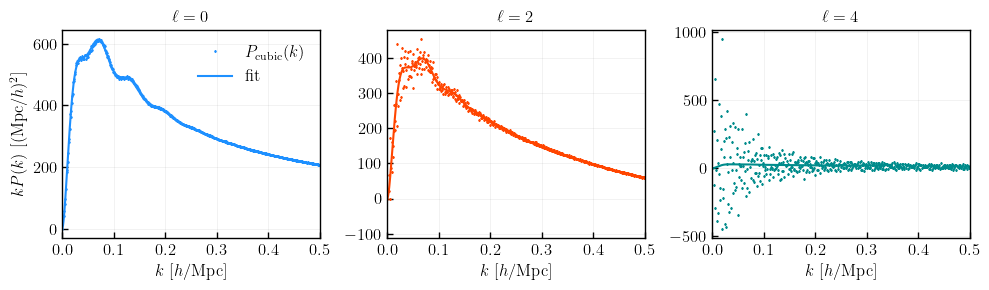

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(cubic_pk['k'][ill], cubic_pk['k'][ill] * cubic_pk['data'][ill], color='C{}'.format(ill), marker='d', markersize=1, ls='', label=r'$P_{\mathrm{cubic}}(k)$')
    axes[ill].plot(wm.xin[ill], wm.xin[ill] * pk_theory[ill], color='C{}'.format(ill), ls='-', label=r'fit')
    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlabel(r'$k$ [$h$/Mpc]')
    axes[ill].set_xlim((0, 0.5))
    
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.show()

### $W(k, k^{\prime}) \times P_{\mathrm{theory}}(k^{\prime})$

In [11]:
wm_pk = (wm.value.T.dot(pk_theory.flatten())).reshape((len(ells), wm.shape[1]//len(ells)))

## $P_{\mathrm{cutsky}}(k)$

In [12]:
if source == 'desi':
    fn = DESIFileName()
    fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness, baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
elif source == 'local':
    fn = LocalFileName()
    fn.set_default_config(mockgen=catalog, tracer=tracer, region=region, completeness=completeness)
    fn.update(cellsize=6)
    
cutsky_pk = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut, zrange=zrange) for imock in range(25)], xlim={ell: krange for ell in ells})

In [13]:
fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1/complete/2pt/mock24/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran18_cellsize6_boxsize9000.npy'

### Model fitted on $P_{\mathrm{cutsky}}(k)$

In [14]:
#data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/'

#template_name = 'shapefitqisoqap'

#if rpcut:
#    cutflag = '_rpcut{:.1f}'.format(rpcut)
#elif thetacut:
#    cutflag = '_thetacut{:.2f}'.format(thetacut)
#else:
#    cutflag = ''

#emulator_dir = os.path.join(data_dir, 'emulators/emulators_{}_ELG_LOP'.format(template_name))
#profiles_dir = os.path.join(data_dir, 'profiles/Y1secondgenmocks/profiles_{}_ELG_LOP_complete_SGC'.format(template_name))
#profile_cutsky = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors{}{}.npy'.format(cutflag, '_directedges' if cutflag else '')))

In [15]:
#from emulator_fit import get_power_likelihood

#likelihood = get_power_likelihood(source=source, catalog='second', tracer='ELG_LOP', region='SGC', completeness=True, solve=False, rp_cut=rpcut, theta_cut=thetacut, emulator_fn=os.path.join(emulator_dir.format('complete_'), 'power_{{}}.npy'))

#likelihood.solved_default = '.best'
#likelihood(**profile_cutsky.bestfit.choice(input=True))
#cutsky_obs = likelihood.observables[0]
#pk_obs = cutsky_obs.theory

### Y1 covariance

In [16]:
from cov_utils import truncate_cov
#cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/cov_gaussian_pre_ELG_LOPnotqso_{}_{:.1f}_{:.1f}_default_FKP_lin.txt'.format(region, zrange[0], zrange[1])
#cov = np.loadtxt(cov_fn)
#cov = truncate_cov(cov, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(*krange))
cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_{}_ffa_{}_z{:.3f}-{:.3f}_k{:.2f}-{:.2f}.npy'.format('ELG_LOP', region, zrange[0], zrange[1], krange[0], krange[1])
cov = np.load(cov_fn)

stdY1 = np.sqrt(np.diag(cov)).reshape((3, len(cov[0])//3))

In [17]:
print(cov_fn)

/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_GCcomb_z1.100-1.600_k0.02-0.20.npy


In [18]:
new_krange = np.arange(0, 0.4, 0.005)
#masknew = np.logical_and(new_krange >= 0.02, new_krange < 0.2)
masknew = np.logical_and(new_krange >= krange[0], new_krange < krange[1])

In [19]:
len(stdY1[0])

36

In [20]:
#precmatrix = np.linalg.inv(cov)
#deriv = wm.value
#derivp = deriv.dot(precmatrix)
#fisher = derivp.dot(deriv.T)
#shotnoise = np.zeros_like(cutsky_pk['data'].flatten())
#shotnoise[:len(cutsky_pk['data'][0])] = np.full_like(cutsky_pk['data'][0], cutsky_pk['shotnoise'])
#shotnoise_value = np.linalg.solve(fisher, derivp.dot(cutsky_pk['data'].flatten() + shotnoise - wm_pk.flatten()))
#pk_theory_shotnoise = wm_pk.flatten() + shotnoise_value.dot(deriv) - shotnoise
#wm_pk_shotnoise = pk_theory_shotnoise.reshape((len(ells), wm.shape[1]//len(ells)))

In [21]:
def wm_pk_shotnoise(pk_theory, shotnoise, cutsky_shotnoise=cutsky_pk['shotnoise']):
    pk_th = np.array(pk_theory.copy())
    pk_th[0] += np.full_like(pk_th[0], shotnoise)
    wm_pk_shotnoise = (wm.value.T.dot(pk_th.flatten())).reshape((len(ells), wm.shape[1]//len(ells)))
    wm_pk_shotnoise[0] -= cutsky_shotnoise
    return wm_pk_shotnoise

def chi2(shotnoise):
    precmatrix = np.linalg.inv(cov)
    r = (wm_pk_shotnoise(pk_theory, shotnoise) - cutsky_pk['data']).flatten()
    res = r.T.dot(precmatrix.dot(r))
    return res

from scipy.optimize import minimize

minimizer = minimize(chi2, x0=cutsky_pk['shotnoise'])
print(minimizer)
shotnoise = minimizer.x[0]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.32045271054548
        x: [ 2.166e+03]
      nit: 3
      jac: [ 3.099e-06]
 hess_inv: [[ 9.718e+01]]
     nfev: 12
     njev: 6


In [22]:
plt.rcParams["figure.autolayout"] = False

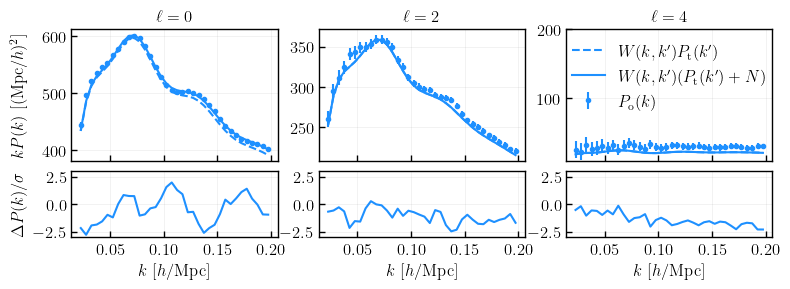

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(8, 3), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].errorbar(cutsky_pk['k'][ill], cutsky_pk['k'][ill] * cutsky_pk['data'][ill], cutsky_pk['k'][ill]*stdY1[ill]/5., color='C0', marker='.', ls='', label=r'$P_{\mathrm{o}}(k)$')
    #axes[0][ill].plot(cutsky_obs.k[ill], cutsky_obs.k[ill] * cutsky_obs.theory[ill], color='C{:d}'.format(ill), linestyle='--', label=r'$P_{\mathrm{cutsky}}(k)$ fit')
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * wm_pk[ill], color='C0', ls='--', label=r'$W(k, k^{\prime}) P_{\mathrm{t}}(k^{\prime})$')
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * wm_pk_shotnoise(pk_theory, shotnoise)[ill], color='C0', ls='-', label=r'$W(k, k^{\prime}) (P_{\mathrm{t}}(k^{\prime}) + N)$')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))
    #axes[0][ill].set_ylim(ymin=0)
    
    #axes[1][ill].plot(wm.xout[ill], (wm_pk[ill] - cutsky_pk['data'][ill])/(stdY1[ill]/5.), color='C0', ls='--')
    axes[1][ill].plot(wm.xout[ill], (wm_pk_shotnoise(pk_theory, shotnoise)[ill] - cutsky_pk['data'][ill])/(stdY1[ill]/5.), color='C0', ls='-')
    #axes[1][ill].plot(wm.xout[ill], (wm_pk[ill] - cutsky_obs.theory[ill])/stdY1[ill], color='C0', linestyle='--')
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    axes[1][ill].set_ylim((-3, 3))

axes[0][2].set_ylim(ymax=200)
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$\Delta P(k) / \sigma$')
axes[0][2].legend(loc='upper center')
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, cubicsource, 'window_validation_{}mocks{}_{}cut{:.2f}_{}_{}_z{:.2f}-{:.2f}_ktmax{}.pdf'.format(len(imocks), '_ffa' if completeness=='ffa' else '_complete' if completeness else '_altmtl', 'rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zrange[0], zrange[1], ktmax)), dpi=200)
plt.show()